# Model Comparison for Cognitive Models
Part 1: Non-Hierarchical Model Comparison.

by Lasse Elsemüller

## Table of Contents
 * [Introduction](#introduction)
 * [Generative Model Definition](#generative_model_definition)
	 * [Priors](#priors)
	 * [Creating Simulators](#creating_simulators)
	 * [Prior Predictive Checks](#prior_predictive_checks)
 * [Defining the Neural Approximator](#defining_the_neural)
	 * [Defining the Configurator](#defining_the_configurator)
	 * [Defining the Trainer](#defining_the_trainer)
 * [Training Phase](#training_phase)
 * [Network Validation](#network_validation)
 * [Network Application](#network_application)

In [ ]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from scipy import stats

import bayesflow as bf

## Introduction <a class="anchor" id="introduction"></a>

This tutorial series contains workflows for comparing competing probabilistic models via posterior model probabilities (PMPs) or Bayes Factors (BFs) with BayesFlow. We start with non-hierarchical model comparison in this tutorial (part 1), while [part 2](./Hierarchical_Model_Comparison_MPT.ipynb) will look at the modifications that allow us to compare hierarchical models. To keep the content concise, the focus will be on the model comparison steps themselves. For a comprehensive overview of the different functionalities BayesFlow has to offer, see the ["Principled Amortized Bayesian Workflow for Cognitive Modeling"](./LCA_Model_Posterior_Estimation.ipynb) tutorial notebook.

## Generative Model Definition <a class="anchor" id="generative_model_definition"></a>


In this tutorial, we will compare simple Multinomial Processing Tree (MPT) models. They are a popular class of stochastic models in cognitive psychology aiming to explain observed categorical decision data by a branched structure of discrete latent processes. We embed the tutorial within the scenario of an old-new-recognition task. In this task, participants memorize a list of stimulus items (e.g., words) and indicate in a subsequent phase whether a presented stimulus was shown before ('old' decision) or is a distractor item ('new' decision).

More specifically, we compare two classic MPT models: The basic one-high-threshold (1HT) model and the popular two-high-threshold (2HT) model.

The 1HT model can be considered as the simplest model formulation: For old items, it assumes that participants either recognize an item or if they do not, guess whether it is old and new. For new items, it assumes that participant directly initiate a guessing process.

The 2HT model extends the process assumed for new items by proposing a similar process as for new items, such that participants either recognize a stimulus as new directly and only if they do not enter the guessing process. This model frequently explains categorical decision data much better than the 1HT model.

For further information on MPT models and the 1HT and 2HT instantiations see [Erdfelder et al. (2009)](https://psycnet.apa.org/record/2009-21670-002).

By traversing the branches of the trees, we obtain the equations for each outcome category. For these equations, we encode 'old' items as 1 and 'new' items as 0. Further, the first index of the response probabilities indicates the stimulus type and the second the response. Thus, $p_{11}$ stands for the probability to correctly recognize a previously presented stimulus, while $p_{01}$ stands for a false alarm (identifying a distractor item as 'old').

In order to make the 2HT model identifiable, we follow the convention of assuming equal probabilities for recognizing old items and identifying new items.

<img src=img/1HT2HT.png width="1000" height="500" />

One-high-threshold (1HT) MPT model:

$$
\begin{align}
p_{11} &= d + (1-d)*g \\
p_{10} &= (1-d)*(1-g) \\
p_{01} &= g \\
p_{00} &= (1-g) \\
x_1 &\sim \textrm{Bernoulli}(p_{11}) \\
x_0 &\sim \textrm{Bernoulli}(p_{01})
\end{align}
$$


Two-high-threshold (2HT) MPT model:

$$
\begin{align}
p_{11} &= d + (1-d)*g \\
p_{10} &= (1-d)*(1-g) \\
p_{01} &= (1-d)*g \\
p_{00} &= d + (1-d)*(1-g) \\
x_1 &\sim \textrm{Bernoulli}(p_{11}) \\
x_0 &\sim \textrm{Bernoulli}(p_{01})
\end{align}
$$

### Priors <a class="anchor" id="priors"></a>


Our models only have two parameters: $d$ for recognition and $g$ for guessing. As both parameters represent probabilities, we choose moderately informative beta priors with 2 for both shape parameters.

In [2]:
PARAM_NAMES = [r"$d$", r"$g$"]

In [3]:
def prior_fun(rng=None):
    "Samples a random parameter configuration from the prior distribution."
    if rng is None:
        rng = np.random.default_rng()

    d = rng.beta(a=2, b=2)
    g = rng.beta(a=2, b=2)
    return np.r_[d, g]

The BayesFlow ``Prior`` wrapper provides us further utilities for inspecting our chosen parameter prior:

In [4]:
prior = bf.simulation.Prior(prior_fun=prior_fun, param_names=PARAM_NAMES)

We can sample from the constructed prior, with the argument ``batch_size`` governing the number of draws. For instance, calling the prior with ``batch_size=5`` will return a dictionary, containing, among others, an entry ``prior_draws`` which holds 5 random draws from the prior in the form of a $5 \times 2$ matrix:

In [5]:
prior(batch_size=5)

{'prior_draws': array([[0.60567859, 0.21211342],
        [0.53302919, 0.50565267],
        [0.30158864, 0.87688014],
        [0.5178926 , 0.57265337],
        [0.70948297, 0.88509065]]),
 'batchable_context': None,
 'non_batchable_context': None}

Note, that the prior also returned some other stuff, which allows for more flexible priors (e.g., parametric priors or prior sensitivity analysis). To inspect whether our chosen prior is sensible, we can conduct some prior predictive checks in the parameter space. The simplest one is to simply visualize our prior draws:

/home/radevs/anaconda3/envs/BayesFlowDev/lib/python3.10/site-packages/seaborn/axisgrid.py:64: UserWarning: The figure layout has changed to tight
  self.fig.tight_layout(*args, **kwargs)


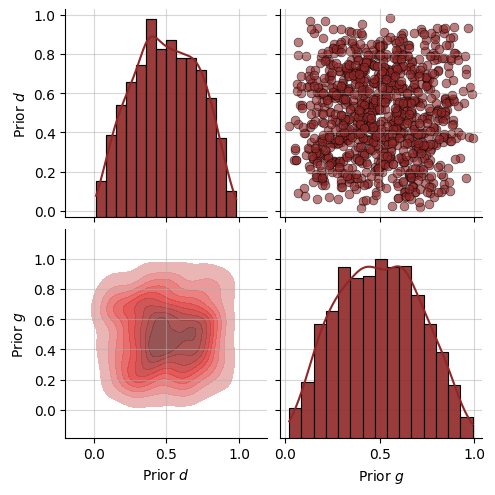

In [6]:
f = prior.plot_prior2d(n_samples=1000)

We see that our beta priors symmetrically concentrate the probability mass around .5, but still consider more extreme parameter values possible.

### Creating Simulators <a class="anchor" id="creating_simulators"></a>


Next, we translate the model equations above into a simulator from which we can generate simulated observational data. Since both models are nested, we can use a single simulator function. For non-nested models, we would construct one function for each computational model.

We will apply BayesFlow to the trial-level data, as this is much more instructive and generalizes to other applications, noting that traditional MPT models use aggregated data. We therefore do not directly implement the multinomial likelihood stated above (which would results in a single row per participant) but decompose it into Bernoulli draws to generate as many rows per participant as trials. As our binary category probabilities add up to 1, we only need the probabilities for old responses, $p_{11}$ and $p_{01}$.

One could additionally add context variables here to include varying trial numbers for instance (see the ["Principled Amortized Bayesian Workflow for Cognitive Modeling"](https://github.com/stefanradev93/BayesFlow/blob/master/docs/source/tutorial_notebooks/LCA_Model_Posterior_Estimation.ipynb) tutorial).

In [7]:
N_OBS = 100

In [8]:
def mpt_simulator(theta, model, num_obs, rng=None, *args):
    """Simulates data from a 1HT or 2HT MPT model, assuming equal proportions of old and new stimuli.

    Parameters
    ----------
    theta : np.ndarray of shape (num_parameters,)
        Contains draws from the prior distribution for each parameter.
    model : str, either "1HT" or "2HT"
        Decides the model to generate data from.
    num_obs : int
        The number of observations (trials).

    Returns
    -------
    data     : np.ndarray of shape (num_obs, 2)
        The generated data set. Contains two columns:
            1. Stimulus type (0="new", 1="old")
            2. Response (0="new", 1="old")
    """
    if rng is None:
        rng = np.random.default_rng()

    obs_per_condition = int(np.ceil(num_obs / 2))

    # Compute category probabilities per model
    d, g = theta

    if model == "1HT":
        p_11 = d + (1 - d) * g
        p_01 = g

    elif model == "2HT":
        p_11 = d + (1 - d) * g
        p_01 = (1 - d) * g

    else:
        raise NotImplementedError("Model not understood")

    # Create a vector of stimulus types
    stims = np.repeat([[1, 0]], repeats=obs_per_condition, axis=1).T

    # Simulate responses
    resp_old_items = rng.binomial(n=1, p=p_11, size=obs_per_condition)[:, np.newaxis]
    resp_new_items = rng.binomial(n=1, p=p_01, size=obs_per_condition)[:, np.newaxis]
    resp = np.concatenate((resp_old_items, resp_new_items), axis=0)

    # Create final data set
    data = np.concatenate((stims, resp), axis=1)

    return data

We now pass our custom prior and simulator functions to the ``GenerativeModel`` wrapper. Here, we use the ``partial`` function to provide the arguments for each model. If you provided context variables before, you could use a wrapper for your simulator function beforehand. In this case, specifying ``simulator_is_batched`` would not be necessary.

In [9]:
model_1ht = bf.simulation.GenerativeModel(
    prior=prior_fun,
    simulator=partial(mpt_simulator, model="1HT", num_obs=N_OBS),
    name="1HT",
    simulator_is_batched=False,
)

model_2ht = bf.simulation.GenerativeModel(
    prior=prior_fun,
    simulator=partial(mpt_simulator, model="2HT", num_obs=N_OBS),
    name="2HT",
    simulator_is_batched=False,
)

INFO:root:Performing 2 pilot runs with the 1HT model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 2)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 100, 2)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.
INFO:root:Performing 2 pilot runs with the 2HT model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 2)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 100, 2)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


We can now inspect all the components contained in our finished generative models by calling them:

In [10]:
model_output = model_1ht(batch_size=5)
print(model_output.keys())

dict_keys(['prior_non_batchable_context', 'prior_batchable_context', 'prior_draws', 'sim_non_batchable_context', 'sim_batchable_context', 'sim_data'])


In [11]:
print("Shape of data batch:", model_output["sim_data"].shape)
print("First 3 rows in first data set:")
print(model_output["sim_data"][0, :3, :])

Shape of data batch: (5, 100, 2)
First 3 rows in first data set:
[[1 1]
 [1 1]
 [1 1]]


As a last step that is specific to model comparison, we combine all generative models using the ``MultiGenerativeModel`` wrapper. This is necessary because during the training process, we want to generate data from not just one, but all candidate models. The wrapper assumes the common case of equal prior model probabilities, but we could also supply other probabilities via the ``model_probs`` argument.

In [12]:
generative_models = bf.simulation.MultiGenerativeModel([model_1ht, model_2ht])

### Prior Predictive Checks <a class="anchor" id="prior_predictive_checks"></a>


Now that we fully implemented the generative models as simulators, we can conduct the final model building step by checking the faithfulness of the resulting data patterns. For this, we implement prior predictive checks on the data level in three steps: 

1. Simulate a large number of data sets (= participants) from each model
2. Compute meaningful summary statistics (here: hit rates and false-alarms rates) for each model 
3. Plot the resulting data summaries for each model

In [13]:
# 1. Data simulation
sim_ppcheck_1ht = model_1ht(batch_size=1000)
sim_ppcheck_2ht = model_2ht(batch_size=1000)

In [14]:
# 2. Summary statistics
def get_rates(sim_data):
    """Get the hit rate and false alarm rate for each data set (= participant) in a batch of data
    sets simulating binary decision (recognition) tasks.
    Assumes first half of data to cover old items and second half to cover new items."""

    obs_per_condition = int(np.ceil(sim_data.shape[-2] / 2))
    hit_rates = np.mean(sim_data[:, :obs_per_condition, 1], axis=-1)
    fa_rates = np.mean(sim_data[:, obs_per_condition:, 1], axis=-1)

    return hit_rates, fa_rates


rates_1htm = get_rates(sim_ppcheck_1ht["sim_data"])
rates_2htm = get_rates(sim_ppcheck_2ht["sim_data"])
rates = [rates_1htm, rates_2htm]

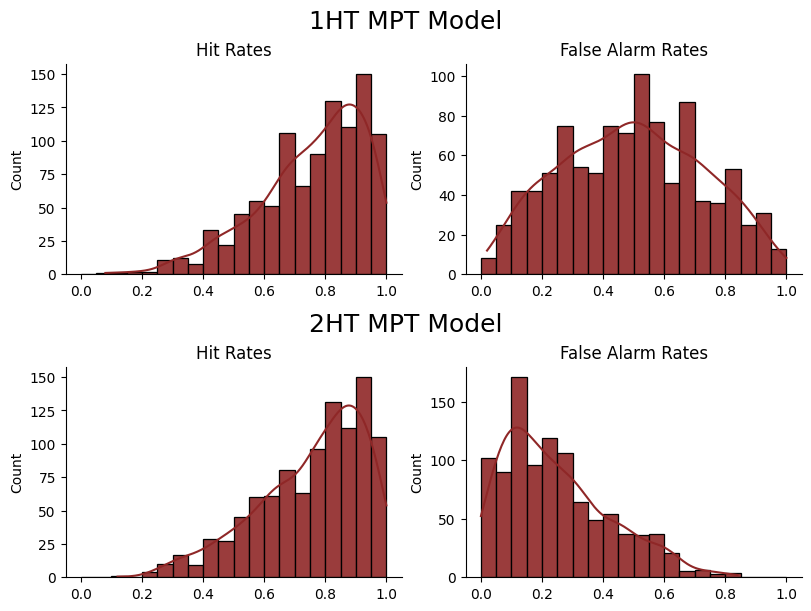

In [15]:
# 3. Plot rates across all data sets
fig = plt.figure(constrained_layout=True, figsize=(8, 6))
subfigs = fig.subfigures(nrows=2, ncols=1)
model_names = ["1HT MPT Model", "2HT MPT Model"]
num_bins = 20
bins = np.linspace(0.0, 1.0, num_bins + 1)

for row, subfig in enumerate(subfigs):
    subfig.suptitle(model_names[row], fontsize=18)
    axs = subfig.subplots(nrows=1, ncols=2)
    sns.histplot(rates[row][0].flatten(), bins=bins, kde=True, color="#8f2727", alpha=0.9, ax=axs[0]).set(
        title="Hit Rates"
    )
    sns.histplot(rates[row][1].flatten(), bins=bins, kde=True, color="#8f2727", alpha=0.9, ax=axs[1]).set(
        title="False Alarm Rates"
    )
sns.despine()

Unsurprisingly, we observe similar hit rates for both models, as they assume the same latent processes for old items. Their difference in assumptions concerning new items manifests in the false alarm rates: The symmetric beta prior on the $g$ parameter directly translates into false alarm rates around ~.5 for the 1HT model. For the 2HT model, the additional recognition stage set before the guessing process lowers the false alarm rate to ~.25.

## Defining the Neural Approximator <a class="anchor" id="defining_the_neural"></a>


We assured the faithfulness of our simulator and can move on to building a neural approximator for the Bayesian model comparison task. Our first network is a summary network that reduces the dimensionality of our data.[^1] We assume our data to be independent and identically distributed (iid) and thus choose a ``DeepSet`` network that is aligned to this probabilistic symmetry.

[^1]: This is admittedly a slight overkill for our very simple models, since we could compute perfect summary statistics directly here.

In [ ]:
summary_net = bf.summary_networks.DeepSet()

Next, we choose the inference network for our current inference task. For model comparison, we select the ``PMPNetwork`` which approximates posterior model probabilities (that we could subsequently transform into Bayes factors if desired).

In [17]:
inference_net = bf.inference_networks.PMPNetwork(num_models=2, dropout=False)

Finally, we use the ``AmortizedModelComparison`` wrapper to connect the two networks.

In [18]:
amortizer = bf.amortizers.AmortizedModelComparison(inference_net, summary_net)

### Defining the Configurator <a class="anchor" id="defining_the_configurator"></a>


We can use a configurator to mediate between the simulators and the amortizer containing the networks. It transforms data into a suitable format for the neural networks, which are here two elements: The simulated data sets and the indices of the generating model for each data set. For this, we will simply use the ``DefaultModelComparisonConfigurator`` which is automatically initialized by the trainer instance (see below). We will also use the configurator later on, when validating the trained network, for convenient data transformations.

### Defining the Trainer <a class="anchor" id="defining_the_trainer"></a>


Now, we can reward ourselves for our hard work and bring all previous elements of our workflow together. We pass them to the ``Trainer`` class, which handles all aspects of the training process for us. If desired, we could also pass it a ``checkpoint_path`` where it regularly saves the trained network so we can reuse it. The consistency check assures us that there should be no major bugs preventing in our training workflow from simulating the data to updating the network weights.

In [19]:
trainer = bf.trainers.Trainer(
    amortizer=amortizer,
    generative_model=generative_models,
)

INFO:root:Performing a consistency check with provided components...
2023-09-09 16:48:10.901555: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
INFO:root:Done.


The ``summary`` function gives us a quick overview of the network component sizes:

In [20]:
amortizer.summary()

Model: "amortized_model_comparison"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pmp_network (PMPNetwork)    multiple                  9154      
                                                                 
 deep_set (DeepSet)          multiple                  67466     
                                                                 
Total params: 76620 (299.30 KB)
Trainable params: 76620 (299.30 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Training Phase <a class="anchor" id="training_phase"></a>


Our simple simulators are extremly fast, so we can use online training (simulating the data on the fly during training). Here, we use $10$ epochs with $500$ iterations each and a batch size of $64$ simulations. This means that we use $10 \times 500 \times 64 = 320,000$ unique simulations in total for training our neural network. We can do this because the simulators are trivial to implement and thus very efficient to run. Training should take a couple of seconds to complete.

In [ ]:
%%time
losses = trainer.train_online(epochs=10, iterations_per_epoch=500, batch_size=64)

Right after training finishes, we can inspect how the loss evolved over the training duration:

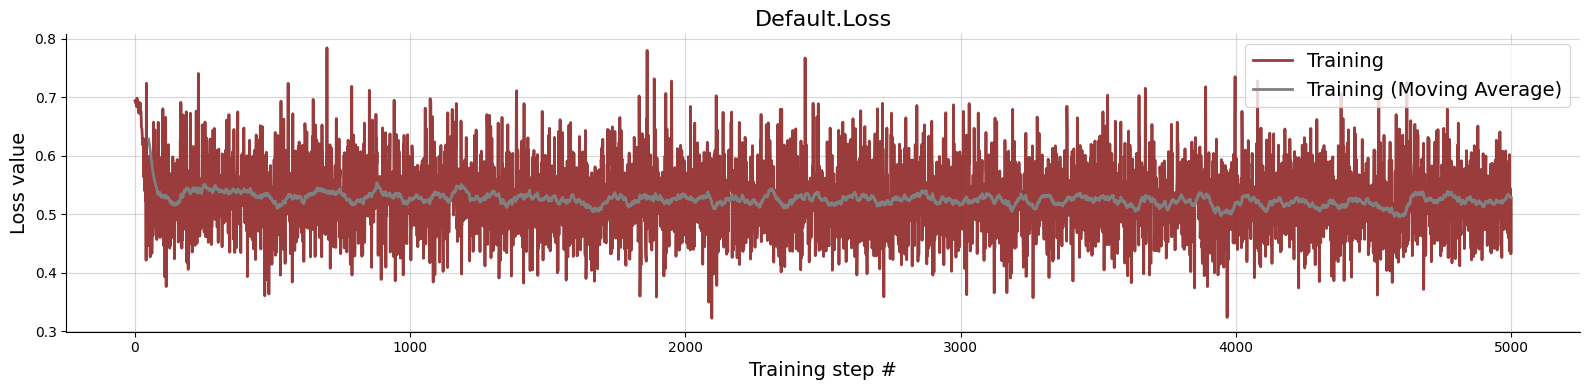

In [22]:
diag_plot = bf.diagnostics.plot_losses(train_losses=losses, moving_average=True)

We see that the network picked up the important parts of the task very fast and plateaued afterwards, which indicates that we have had more than enough training steps.

## Network Validation <a class="anchor" id="network_validation"></a>


The ability of our amortized networks to quickly process thousands of simulated data sets opens up new possibilities for validating our method prior to applying it. Let's first simulate some data from our models and use the configurator to quickly transform it:

In [23]:
# Generate 1000 validation data sets
sim_data = generative_models(1000)

# Use the configurator to transform the data structure
sim_data_transformed = trainer.configurator(sim_data)

# Get true indices and predicted PMPs from the trained network
sim_indices = sim_data_transformed["model_indices"]
sim_preds = amortizer(sim_data_transformed)

We first ask the most important question: Do our approximated PMPs correspond to some ground-truth? We can approach this question by looking at the _calibration_. It measures the closeness of the PMPs to the true underlying probabilities of our simulated data.

We assess it with ``plot_calibration_curves``, which provides us with three important pieces of information for each model:
1. The calibration curve, where we bin the predicted PMPs and contrast the bin means with the true probability for the respective model in each bin
2. The marginal histogram of the bins, which tells us how stable the calibration curve is by showing the fraction of predictions in each bin
3. The expected calibration error (ECE), a numerical measure of the calibration curve's divergence that takes the binning distribution into account

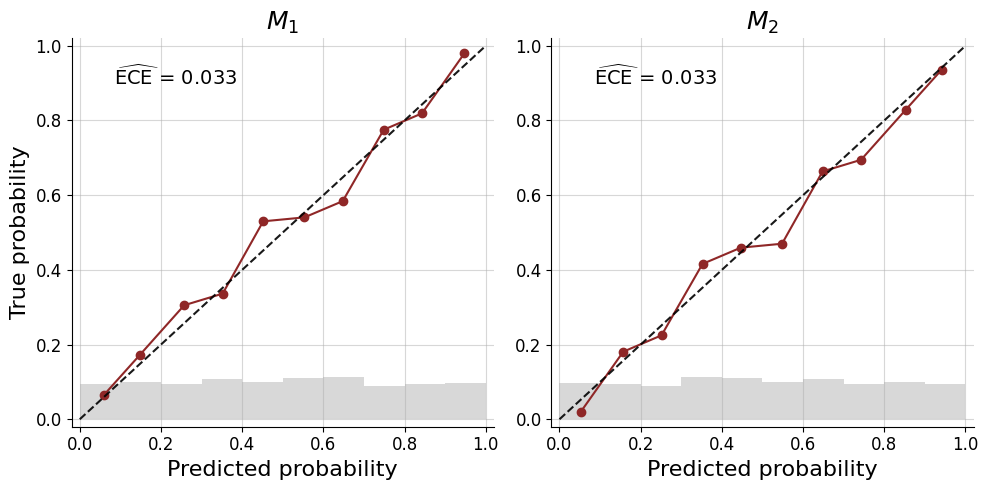

In [24]:
cal_curves = bf.diagnostics.plot_calibration_curves(true_models=sim_indices, pred_models=sim_preds)

We observe a close alignment of the calibration curve to the diagonal without systematic over- or underconfidence. The ECE being close 0 also confirms that our neural approximator produces highly calibrated PMPs.
We can further inspect our approximator by examing the confusion matrix for our simulated data sets:

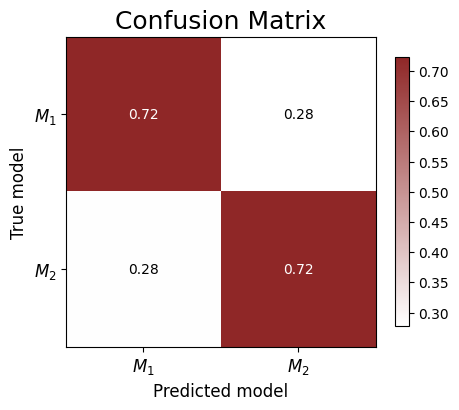

In [25]:
conf_matrix = bf.diagnostics.plot_confusion_matrix(true_models=sim_indices, pred_models=sim_preds)

We see that in ~72% of simulated data sets the underlying model is correctly detected. By increasing the training duration and/or size of the neural networks, we could check whether our classifier is performing suboptimally or we already reached the upper bound performance that our sparse data allow for. The excellent calibration that we observed before suggests the second option here. 

## Network Application <a class="anchor" id="network_application"></a>


Finally, we can apply our trained network to our observed data. To demonstrate this, we simulate some data from the 2HT model. We quickly redefine our generating process with a fixed random seed to obtain reproducible outcomes:

In [26]:
fixed_rng = np.random.default_rng(2023)
prior_fixed = bf.simulation.Prior(prior_fun=partial(prior_fun, rng=fixed_rng), param_names=PARAM_NAMES)
fake_data_generator = bf.simulation.GenerativeModel(
    prior=prior_fixed,
    simulator=partial(mpt_simulator, model="2HT", num_obs=N_OBS, rng=fixed_rng),
    skip_test=True,
    simulator_is_batched=False,
)

fake_data = fake_data_generator(batch_size=1)["sim_data"]
print(fake_data.shape)

(1, 100, 2)


Our simulated data already has the required (number of data sets, number of observations, number of variables) shape, so we can directly proceed and have a look at the hit rate and the false alarm rate of our fake participant:

In [27]:
get_rates(fake_data)

(array([0.88]), array([0.02]))

Here, we see very low false alarm rate that the 1HT model struggles to explain, so we would expect our neural approximator to assign higher evidence to the 2HT model.

In [28]:
# Way 1: Amortizer with dictionary input
amortizer.posterior_probs({"summary_conditions": fake_data})[0]

array([0.04058154, 0.9594184 ], dtype=float32)

In [29]:
# Way 2: Raw data into summary network -> inference network
embeddings = summary_net(fake_data)
preds = inference_net.posterior_probs(embeddings)[0]
print(preds.numpy())

[0.04058154 0.9594184 ]


As expected, the PMPs are in favor of the 2HT model. We assumed equal prior model probabilities, so the transformation of these results into a Bayes factor is straightforward:

In [30]:
bayes_factor21 = preds[1] / preds[0]
print(bayes_factor21.numpy())

23.641743


Corresponding to the PMPs, the Bayes factor assigns higher evidence to the 2HT model. Despite only having 100 binary observations at hand, the data are so untypical for the 1HT that the Bayes factor reflects the data being much more likely under the 2HT model compared to the 1HT model.

Congratulations, you now know how to conduct amortized Bayesian model comparison with BayesFlow! When you feel ready to find out how to compare hierarchical models, continue with [Part 2](./Hierarchical_Model_Comparison_MPT.ipynb).
